# Predict 2m temperature in Europe using z500

The goal is to predict gridded 2m temperature (t2m) in Europe/North Atlantic region based on geopotential at 500 hPa (z500) from the previous day.    
Three different models are trained and tested:

- baseline: climatoloy and persistence
- linear regression using sklearn
- Convolutional neural network (CNN) using Keras

Note: This notebook is inspired by the [WeatherBench](https://github.com/pangeo-data/WeatherBench) project.

TO DO's:
- improve calculation of anomaly: with respect to moving window!

## Baseline: Climatology and Persistence 

- Persistence = Tomorrow's temperature is the same as today's temperature.  
- Climatology = The temperature is the same for all days of the year.

In [55]:
# import packages
import numpy as np
import xarray as xr
from src.score import *

In [56]:
# Load the entire dataset for the relevant variables
DATADIR = '/home/steidani/windows/data/ParetoBoost/'  # Location of ERA5 dataset at 1.875° resolution, hourly from 1979 to 2021
data = xr.open_mfdataset(f'{DATADIR}t2m/2m_temperature*.nc', combine='by_coords')

In [57]:
# We regrid the data to a lower resolution for faster computation and rename latitude/longitude to lat/lon

resol = 3.75 # 32 x 16 grid over NA/Europe
#resol =  5.625 # 22 x 11 grid over NA/Europe

import collections.abc
#xesmf needs the following aliases, otherwise it will not work
collections.Iterable = collections.abc.Iterable
import xesmf as xe

if 'latitude' in data.coords:
    data = data.rename({'latitude': 'lat', 'longitude': 'lon'})

# Create output grid
grid_out = xr.Dataset(
    {
        'lat': (['lat'], np.arange(30, 90, resol)),
        'lon': (['lon'], np.arange(-60, 60, resol)),
    }
)

# Create regridder
regridder = xe.Regridder(
    data, grid_out, 'bilinear', periodic=True,
    )

data = regridder(data)

In [58]:
# daily mean
data = data.resample(time='1D').mean()

In [59]:
# Split into train and test data.
data_train = data.sel(time=slice('1979', '2016')) # used for climatology
data_test = data.sel(time=slice('2017', '2018')) # used for persistence
del data

### Climatology

In [60]:
def create_climatology_forecast(ds):
    return ds.mean('time')

# calculate climatology forecasts: mean from 1979 to 2016
climatology = create_climatology_forecast(data_train)

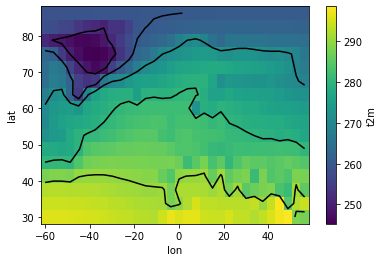

In [67]:
climatology.t2m.plot()
climatology.t2m.plot.contour(colors="black")

In [62]:
compute_weighted_rmse(climatology, data_test).compute().values

<bound method Mapping.values of <xarray.Dataset>
Dimensions:  ()
Data variables:
    t2m      float64 7.07>

pretty bad, but climatology is not very good predictor

### Persistence

In [51]:
# calculate persistence forecasts
def create_persistence_forecast(ds, lead_time):
    assert lead_time > 0, 'Lead time must be greater than 0'
    X = ds.isel(time=slice(0, -lead_time))
    valid_time = ds.isel(time=slice(lead_time, None)).time
    X['time'] = valid_time
    return X

lead_time = 1
persistence = create_persistence_forecast(data, lead_time)

In [64]:
compute_weighted_rmse(persistence, data_test).compute().values

<bound method Mapping.values of <xarray.Dataset>
Dimensions:  ()
Data variables:
    t2m      float64 1.957>

- pretty good, but not surprising: Tomorrow's temperature is not very different from today's
- increasing the lead time quickly leads to a worse prediction

## Linear Regression

In [68]:
# import packages
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import pickle
from src.score import *
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from tqdm import tqdm_notebook as tqdm

In [69]:
# Load the entire dataset for the relevant variables
DATADIR = '/home/steidani/windows/data/ParetoBoost/'  # Location of ERA5 dataset at 1.875° resolution, hourly from 1979 to 2021
z500 = xr.open_mfdataset(f'{DATADIR}z500/geopotential_500*.nc', combine='by_coords')
t2m = xr.open_mfdataset(f'{DATADIR}t2m/2m_temperature*.nc', combine='by_coords')
data = xr.merge([z500, t2m])

In [70]:
# We regrid the data to a lower resolution for faster computation and rename latitude/longitude to lat/lon

resol = 3.75 # 32 x 16 grid over NA/Europe
#resol =  5.625 # 22 x 11 grid over NA/Europe

import collections.abc
#xesmf needs the following aliases, otherwise it will not work
collections.Iterable = collections.abc.Iterable
import xesmf as xe

if 'latitude' in data.coords:
    data = data.rename({'latitude': 'lat', 'longitude': 'lon'})

# Create output grid
grid_out = xr.Dataset(
    {
        'lat': (['lat'], np.arange(30, 90, resol)),
        'lon': (['lon'], np.arange(-60, 60, resol)),
    }
)

# Create regridder
regridder = xe.Regridder(
    data, grid_out, 'bilinear', periodic=True,
    )

data = regridder(data)

In [71]:
# To further speed up the computation, we use daily means of the data

# daily mean
data = data.resample(time='1D').mean()

In [72]:
# get dimensions
data.dims

Frozen({'time': 15706, 'lat': 16, 'lon': 32})

In [73]:
# Split into train and test data
# Yes, technically we should have a separate validation set but for LR this shouldn't matter.
data_train = data.sel(time=slice('1979', '2016'))
data_test = data.sel(time=slice('2017', '2018'))
del data

In [74]:
# mean and std of the training data. This is how WeatherBench does it!
data_mean = data_train.sel(time=slice("1979-01-01", "2000-12-31")).mean(("time", "lat", "lon")).load() # mean over 20 years to speed up process
data_std = data_train.sel(time=slice("1979-01-01", "2000-12-31")).std("time").mean(("lat", "lon")).load()

# mean/std for each grid separately
#data_mean = data_train.sel(time=slice("1979-01-01", "2000-12-31")).mean("time").load() # mean over 20 years to speed up process
#data_std = data_train.sel(time=slice("1979-01-01", "2000-12-31")).std('time').load()

## Normalize datasets
data_train = (data_train - data_mean) / data_std
data_test = (data_test - data_mean) / data_std

# INFO: 


In [ ]:
# TO DO!!!!!

"""
# anomaly with respect to monthly mean
data_mean = data_train.sel(time=slice("1979-01-01", "2000-12-31")).groupby("time.month").mean("time")
data_std = data_train.sel(time=slice("1979-01-01", "2000-12-31")).groupby("time.month").std("time")
data_train = xr.apply_ufunc(
    lambda x, m, s: (x - m) / s,
    data_train.groupby("time.month"),
    data_mean,
    data_std,
    dask = 'allowed', vectorize = True,
)
data_test = xr.apply_ufunc(
    lambda x, m, s: (x - m) / s,
    data_test.groupby("time.month"),
    data_mean,
    data_std,
    dask = 'allowed', vectorize = True,
)"""

""" 
# Better way to normalize data by using running mean window (remove seasonality) and for each grid separately 

# running window
window = 31
groupby = "dayofyear"

# step 1: long-term daily mean
clim = data_train.sel(time=slice("1979-01-01", "2000-12-31")).groupby('time' + '.' + groupby).mean('time')
clim = clim.chunk({'dayofyear': None})
        
# step 2: running mean (with periodic boundary)
data_mean = clim.rolling(**{groupby:window}, center=True).mean().fillna(
       clim    
       )
data_std = clim.rolling(**{groupby:window}, center=True).std().fillna(
       clim   
       )

# step 3: normalize data
data_train = xr.apply_ufunc(
    lambda x, m, s: (x - m) / s,
    data_train.groupby('time' + '.' + groupby),
    data_mean,
    data_std,
    dask = 'allowed', vectorize = True,
)
data_test = xr.apply_ufunc(
    lambda x, m, s: (x - m) / s,
    data_test.groupby('time' + '.' + groupby),
    data_mean,
    data_std,
    dask = 'allowed', vectorize = True,
"""

In [75]:
# some parameters
_, nlat, nlon = data_train.z.shape; nlat, nlon

(16, 32)

### Train linear regression model

In [76]:
def create_training_data(da, lead_time_h, return_valid_time=False):
    """Function to split input and output by lead time."""
    X = da.isel(time=slice(0, -lead_time_h))
    y = da.isel(time=slice(lead_time_h, None))
    valid_time = y.time
    if return_valid_time:
        return X.values.reshape(-1, nlat*nlon), y.values.reshape(-1, nlat*nlon), valid_time
    else:
        return X.values.reshape(-1, nlat*nlon), y.values.reshape(-1, nlat*nlon)

In [77]:
def train_lr(lead_time_h, input_vars, output_vars, data_subsample=1):
    """Create data, train a linear regression and return the predictions.
       Args:
            lead_time: Lead time in hours
            input_vars: Input variables
            output_vars: Target variables
            data_subsample: take every nth data point
    """
    X_train, y_train, X_test, y_test = [], [], [], []
    for v in input_vars:
        # training
        X, y = create_training_data(data_train[v], lead_time_h)
        X_train.append(X)
        # testing
        X, y, valid_time = create_training_data(data_test[v], lead_time_h, return_valid_time=True)
        X_test.append(X)
    for v in output_vars:
        # training
        X, y = create_training_data(data_train[v], lead_time_h)
        y_train.append(y)
        # testing
        X, y, valid_time = create_training_data(data_test[v], lead_time_h, return_valid_time=True)
        y_test.append(y)
    X_train, y_train, X_test, y_test = [np.concatenate(d, 1) for d in [X_train, y_train, X_test, y_test]]
    
    X_train = X_train[::data_subsample]
    y_train = y_train[::data_subsample]
    
    lr = LinearRegression(n_jobs=16)
    lr.fit(X_train, y_train)
    
    mse_train = mean_squared_error(y_train, lr.predict(X_train))
    mse_test = mean_squared_error(y_test, lr.predict(X_test))
    print(f'Train MSE = {mse_train}'); print(f'Test MSE = {mse_test}')
    preds = lr.predict(X_test).reshape((-1, len(output_vars), nlat, nlon))
    
    fcs = []
    for i, v in enumerate(output_vars):
        fc = xr.DataArray(
            preds[:, i] * data_std[v].values + data_mean[v].values, 
            dims=['time', 'lat', 'lon'],
            coords={
                'time': valid_time,
                'lat': data_train.lat,
                'lon': data_train.lon
            },
            name=v
        )
        fcs.append(fc)
    return xr.merge(fcs), lr   

In [79]:
# Input and output variables
experiments = [
    [['z'], ['t2m']],
]

data_subsample = 1      # 1 = every time step, 5 = every 5th time step, etc.  (to speed up training)
lead_time = 1 #*24
preds = []
models = []
for n, (i, o) in enumerate(experiments):
    print(f'{n}: Input variables = {i}; output variables = {o}')
    # train the model and return predictions and model
    p, m = train_lr(lead_time, input_vars=i, output_vars=o, data_subsample=data_subsample)
    preds.append(p); models.append(m)
    # compute RMSE: on original data
    r = compute_weighted_rmse(p, (data_test * data_std + data_mean)).compute()
    print('; '.join([f'Test RMSE: {v} = {r[v].values}' for v in r]) + '\n')
    # save predictions and model to file
    #p.to_netcdf(f'{PREDDIR}lr_3d_{"_".join(i)}_{"_".join(o)}.nc');
    #to_pickle(m, f'{PREDDIR}/saved_models/lr_3d_{"_".join(i)}_{"_".join(o)}.pkl')

0: Input variables = ['z']; output variables = ['t2m']
Train MSE = 0.17558389902114868
Test MSE = 0.1906297206878662
Test RMSE: t2m = 2.8693429034013294



WOW! This is a very good predictor!

In [80]:
# normalize again for plotting
p = (p - data_mean['t2m']) / data_std['t2m']

Text(0.5, 1.0, '2018-02-27: ERA5')

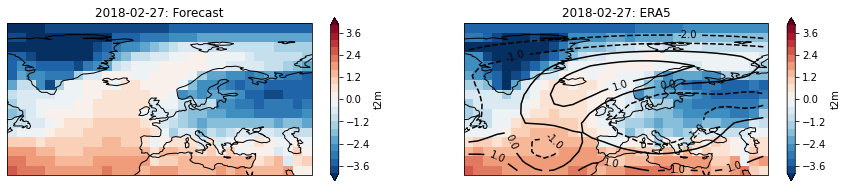

In [82]:
# Let's plot the prediction for an extreme weather event
# Cold Spell in February 2018 (test_data = not seen in training), also known as "Beast from the East": https://en.wikipedia.org/wiki/2018_British_Isles_cold_wave

time = '2018-02-27'
levels = np.arange(-4,4.1,0.4)
fig, axs = plt.subplots(nrows=1,ncols=2,
                        subplot_kw={'projection': ccrs.PlateCarree()},
                        figsize=(15,3))
# Make a filled contour plot
p.sel(time=time).t2m.plot(ax=axs[0], transform=ccrs.PlateCarree(), levels=levels, extend='both', cmap='RdBu_r')
data_test.sel(time=time).t2m.plot(ax=axs[1], transform=ccrs.PlateCarree(), levels=levels, extend='both', cmap='RdBu_r')
cb = data_test.sel(time=time).z.plot.contour(ax=axs[1], transform=ccrs.PlateCarree(), levels=np.arange(-3,3.1,1), colors='black')
cb.clabel(fmt='%2.1f', fontsize=10)

# Add coastlines and extend
for ax in axs.flatten():
    ax.coastlines()

# add title
axs[0].set_title(f'{time}: Forecast')
axs[1].set_title(f'{time}: ERA5')

## Convolutional Neural Network (CNN)

In [83]:
# Depending on your combination of package versions, this can raise a lot of TF warnings... 
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import xarray as xr
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.layers import *
import tensorflow.keras.backend as K
import pickle
from src.score import *
from collections import OrderedDict

In [84]:
print(tf.__version__) # GPU supported since version 1.15
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

2.8.1
Num GPUs Available:  1


In [86]:
def limit_mem():
    """By default TF uses all available GPU memory. This function prevents this."""
    config = tf.compat.v1.ConfigProto()
    config.gpu_options.allow_growth = True
    tf.compat.v1.Session(config=config)

limit_mem()

2022-05-24 16:10:12.017606: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-24 16:10:12.018216: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-24 16:10:12.018715: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-24 16:10:12.019258: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-24 16:10:12.019753: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from S

In [87]:
# Load the entire dataset for the relevant variables
DATADIR = '/home/steidani/windows/data/ParetoBoost/'  # Location of ERA5 dataset at 1.875° resolution, hourly from 1979 to 2021
z500 = xr.open_mfdataset(f'{DATADIR}z500/geopotential_500_*.nc', combine='by_coords')
t2m = xr.open_mfdataset(f'{DATADIR}t2m/2m_temperature_*.nc', combine='by_coords')
data = xr.merge([z500, t2m])

In [88]:
resol = 3.75 # 32 x 16 grid over NA/Europe
#resol =  5.625 # 22 x 11 grid over NA/Europe

import collections.abc
#xesmf needs the following aliases to be done manually.
collections.Iterable = collections.abc.Iterable
import xesmf as xe

if 'latitude' in data.coords:
    data = data.rename({'latitude': 'lat', 'longitude': 'lon'})

# Create output grid
grid_out = xr.Dataset(
    {
        'lat': (['lat'], np.arange(30, 90, resol)),
        'lon': (['lon'], np.arange(-60, 60, resol)),
    }
)

# Create regridder
regridder = xe.Regridder(
    data, grid_out, 'bilinear', periodic=True,
    )

data = regridder(data)

In [89]:
# daily mean (to speed up training)
data = data.resample(time='1D').mean()

In [90]:
# dimensions
data.dims

Frozen({'time': 15706, 'lat': 16, 'lon': 32})

In [91]:
# Split into train and test data
data_train = data.sel(time=slice('1979', '2016')) # part of training will be used for validation
data_test = data.sel(time=slice('2017', '2018'))
del data

In [121]:
# mean and std of the training data

# this is how WeatherBench does it: global mean and std over entire grid
data_mean = data_train.sel(time=slice("1979-01-01", "2000-12-31")).mean(("time", "lat", "lon")).compute() # mean over 20 years to speed up process
data_std = data_train.sel(time=slice("1979-01-01", "2000-12-31")).std('time').mean(('lat', 'lon')).compute()

# mean/std for each grid separately
#data_mean = data_train.sel(time=slice("1979-01-01", "2000-12-31")).mean("time").load() # mean over 20 years to speed up process
#data_std = data_train.sel(time=slice("1979-01-01", "2000-12-31")).std('time').load()


# Better would be to define the mean and std based on moving window (remove seasonality)
# TO DO!

In [122]:
class DataGenerator(keras.utils.Sequence):
    def __init__(self, ds, var_dict, lead_time, batch_size=32, shuffle=True, load=True, mean=None, std=None):
        """
        Data generator for WeatherBench data.
        Template from https://stanford.edu/~shervine/blog/keras-how-to-generate-data-on-the-fly
        Args:
            ds: Dataset containing all variables
            var_dict: Dictionary of the form {'var': level}. Use None for level if data is of single level
            lead_time: Lead time in hours
            batch_size: Batch size
            shuffle: bool. If True, data is shuffled.
            load: bool. If True, dataset is loaded into RAM.
            mean: If None, compute mean from data.
            std: If None, compute standard deviation from data.
        """
        
        # Just copy over the attributes
        self.ds = ds
        self.var_dict = var_dict
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.lead_time = lead_time

        # open dataset with wanted variables
        data = []
        generic_level = xr.DataArray([1], coords={'level': [1]}, dims=['level'])
        for var, levels in var_dict.items():
            try:
                data.append(ds[var].sel(level=levels))
            except ValueError:
                data.append(ds[var].expand_dims({'level': generic_level}, 1))
            except KeyError: # no level index found
                data.append(ds[var])
        self.data = xr.concat(data, 'level').transpose('time', 'lat', 'lon', 'level')                            # STRANGE: all variables are named "z" and are concatenated along level dimension
        
        
        # calculate mean and std if not provided
        self.mean = self.data.mean(('time', 'lat', 'lon')).compute() if mean is None else mean
        self.std = self.data.std('time').mean(('lat', 'lon')).compute() if std is None else std
        # calculate mean and std for each grid cell separately
        #self.mean = self.data.mean('time').compute() if mean is None else mean
        #self.std = self.data.std('time').compute() if std is None else std
        # Normalize
        self.data = (self.data - self.mean) / self.std
        self.n_samples = self.data.isel(time=slice(0, -lead_time)).shape[0]
        self.init_time = self.data.isel(time=slice(None, -lead_time)).time
        self.valid_time = self.data.isel(time=slice(lead_time, None)).time

        self.on_epoch_end()

        # For some weird reason calling .load() earlier messes up the mean and std computations
        if load: print('Loading data into RAM'); self.data.load()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.ceil(self.n_samples / self.batch_size))

    def __getitem__(self, i):
        'Generate one batch of data'
        idxs = self.idxs[i * self.batch_size:(i + 1) * self.batch_size]        
        X = self.data.isel(time=idxs).values[:,:,:,[0]]                                                         # level=0 is z (input)      # Note [:,:,:,[0]] is necessary to keep shape    
        y = self.data.isel(time=idxs + self.lead_time).values[:,:,:,[1]]                                        # level=1 is t2m (target)
        return X, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.idxs = np.arange(self.n_samples)
        if self.shuffle == True:
            np.random.shuffle(self.idxs)

In [123]:
# Create a training and validation data generator. Use the train mean and std for validation as well.
bs = 32
lead_time = 1
var_dict = {'z': None, 't2m': None}
#experiments = [
#    [['z'], ['t2m']],
#]

dg_train = DataGenerator(
    data_train.sel(time=slice('1979', '2015')), var_dict, lead_time,  batch_size=bs, load=True)
dg_valid = DataGenerator(
    data_train.sel(time=slice('2016', '2016')), var_dict, lead_time, batch_size=bs, mean=dg_train.mean, std=dg_train.std, shuffle=False)

# Now also a generator for testing. Important: Shuffle must be False!
dg_test = DataGenerator(
    data_test, var_dict, lead_time, batch_size=bs, mean=dg_train.mean, std=dg_train.std, shuffle=False)

Loading data into RAM
Loading data into RAM
Loading data into RAM


In [124]:
X, y = dg_train[0]
# Batches have dimensions [batch_size, lat, lon, channels]
X.shape, y.shape

((32, 16, 32, 1), (32, 16, 32, 1))

In [125]:
def build_cnn(filters, kernels, input_shape, dr=0):
    """Fully convolutional network
    Template from https://github.com/pangeo-data/WeatherBench"""
    x = input = Input(shape=input_shape)
    for f, k in zip(filters[:-1], kernels[:-1]):
        x = Conv2D(f, k, padding='SAME', strides=1)(x)
        x = LeakyReLU()(x)
        if dr > 0: x = Dropout(dr)(x)
    output = Conv2D(filters[-1], kernels[-1], padding='SAME', strides=1)(x)
    return keras.models.Model(input, output, name="WeatherBench_CNN") 

other cnn network I want to try:
- unet: https://github.com/yihui-he/u-net/blob/master/train.py
- unet: https://git.scc.kit.edu/nk2448/wcbmetric_v2/-/blob/master/calc_wcbmetric_v2.py
- unet: https://github.com/jweyn/DLWP-CS
- unet: https://github.com/hydrogo/rainnet

In [126]:
# build the model
filters = [32, 32, 32, 32, 1]
kernels  = [6, 6, 6, 6, 6]
input_shape =  (16, 32, 1)
cnn = build_cnn(filters, kernels, input_shape) 
cnn.compile(keras.optimizers.Adam(1e-4), 'mse')
cnn.summary()

Model: "WeatherBench_CNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 16, 32, 1)]       0         
                                                                 
 conv2d_25 (Conv2D)          (None, 16, 32, 32)        1184      
                                                                 
 leaky_re_lu_20 (LeakyReLU)  (None, 16, 32, 32)        0         
                                                                 
 conv2d_26 (Conv2D)          (None, 16, 32, 32)        36896     
                                                                 
 leaky_re_lu_21 (LeakyReLU)  (None, 16, 32, 32)        0         
                                                                 
 conv2d_27 (Conv2D)          (None, 16, 32, 32)        36896     
                                                                 
 leaky_re_lu_22 (LeakyReLU)  (None, 16, 32, 32)   

In [133]:
# train the model
cnn.fit(dg_train, epochs=30, validation_data=dg_valid, 
          callbacks=[tf.keras.callbacks.EarlyStopping(
                        monitor='val_loss',
                        min_delta=0,
                        patience=2,
                        verbose=1, 
                        mode='auto'
                    )]
         )

Epoch 1/30
423/423 [==============================] - 2s 5ms/step - loss: 0.2491 - val_loss: 0.2549
Epoch 2/30
423/423 [==============================] - 2s 5ms/step - loss: 0.2481 - val_loss: 0.2583
Epoch 3/30
423/423 [==============================] - 2s 5ms/step - loss: 0.2467 - val_loss: 0.2725
Epoch 3: early stopping


In [98]:
def create_predictions(model, dg):
    """Create predictions for non-iterative model"""
    preds = model.predict(dg)
    # Unnormalize
    preds = preds * dg.std.values + dg.mean.values
    fcs = []
    lev_idx = 0
    for var, levels in dg.var_dict.items():
        if levels is None:
            fcs.append(xr.DataArray(
                preds[:, :, :, lev_idx],
                dims=['time', 'lat', 'lon'],
                coords={'time': dg.valid_time, 'lat': dg.ds.lat, 'lon': dg.ds.lon},
                name=var
            ))
            lev_idx += 1
        else:
            nlevs = len(levels)
            fcs.append(xr.DataArray(
                preds[:, :, :, lev_idx:lev_idx+nlevs],
                dims=['time', 'lat', 'lon', 'level'],
                coords={'time': dg.valid_time, 'lat': dg.ds.lat, 'lon': dg.ds.lon, 'level': levels},
                name=var
            ))
            lev_idx += nlevs
    return xr.merge(fcs)

In [134]:
fc = create_predictions(cnn, dg_test)
r = compute_weighted_rmse(fc, data_test).compute()
print(r)

# normalize for plotting
fc = ((fc.t2m - data_mean.t2m) / data_std.t2m)
t2m_test = ((data_test - data_mean) / data_std)

<xarray.Dataset>
Dimensions:  ()
Data variables:
    z        float64 1.443e+03
    t2m      float64 3.33


RMSE:
- 5.625 resol over Europe, global mean: rmse for t2m = 3.293  
- 5.625 resol over Europe, but with mean/std for each grid separately: rmse for t2m = 3.003  
- 3.75 resol over Europe, global mean/std: rmse for t2m = 3.33
- 3.75 resol over Europe, but with mean/std for each grid separately: rmse for t2m = 3.102  

Text(0.5, 1.0, '2018-2-27: ERA5')

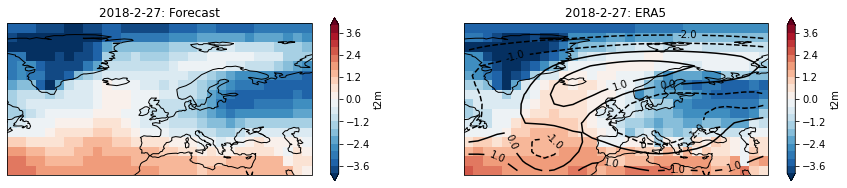

In [132]:
# Let's plot the prediction for an extreme weather event
# Cold Spell in February 2018 (test_data = not seen in training), also known as "Beast from the East": https://en.wikipedia.org/wiki/2018_British_Isles_cold_wave

time = '2018-2-27'
levels = np.arange(-4,4.1,0.4)
fig, axs = plt.subplots(nrows=1,ncols=2,
                    subplot_kw={'projection': ccrs.PlateCarree()},
                        figsize=(15,3))
# Make a filled contour plot
fc.sel(time=time).plot(ax=axs[0], transform=ccrs.PlateCarree(), levels=levels, cmap = 'RdBu_r', extend='both')
t2m_test.t2m.sel(time=time).plot(ax=axs[1], transform=ccrs.PlateCarree(), levels=levels, cmap = 'RdBu_r', extend='both')
cb = t2m_test.z.sel(time=time).plot.contour(ax=axs[1], transform=ccrs.PlateCarree(), levels=np.arange(-3,3.1,1), colors="black")
cb.clabel(fmt='%2.1f', fontsize=10)

# Add coastlines and extend
for ax in axs.flatten():
    ax.coastlines()
    #ax.set_extent([-60, 60, 30, 80], crs=ccrs.PlateCarree())

# add title
axs[0].set_title(f'{time}: Forecast')
axs[1].set_title(f'{time}: ERA5')